# Project 3: Data Warehouse in AWS using S3 and Redshift

## Table of Contents
- [Introduction](#intro)
- [Load credentials](#load)
- [Create clients for IAM, EC2, S3 and Redshift](#create_clients)
- [Check out the sample data sources on S3](#check_s3)
- [Create IAM role](#create_iam_role)
- [Create Redshift cluster](#create_redshift)
- [Open incoming TCP ports in the VPC to access the Redshift cluster](#modify_vpc)
- [Create the Redshift cluster and insert the data](#create_cluster)
- [Analysing data from the Redshift cluster](#analysis)
- [Clean up the Redshift cluster and the IAM role](#clean)

<a id='intro'></a>
## Introduction

First of all, we have to create a `IAM user` in the [AWS Management Console](console.aws.amazon.com).

To that, you have to go to the service `IAM` and then click on `Users` and then the blue button `Add user`. First we have to assing the acces type as `Programmatic access` and then assign the policy `AdministratorAccess` in the `Attach existing policies directly` tab. Once we have the the user created, we save the credentials in the file `dwh.cfg`.

```python
[AWS]
KEY=[USER_KEY]
SECRET=[USER_SECRET]
```

The configuration of the IAM user in the AWS Management Console should look like the next image.

![IAM user](img/iam_user.png)

<a id='load'></a>
# Load credentials

First I will load all the libraries that I will use in this report.

In [82]:
import pandas as pd
import boto3
import json
import configparser
import psycopg2
import seaborn as sns
from botocore.exceptions import ClientError

%matplotlib inline
%load_ext sql

Once we have loaded the libraries and the credentials, we read the configuration file with the credentials to access to AWS and to create the Redshift cluster.

In [88]:
# Read the configuration file
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

# AWS
KEY                    = config.get('AWS','KEY')
SECRET                 = config.get('AWS','SECRET')
ZONE                   = config.get('AWS','ZONE')

# DWH
DWH_CLUSTER_TYPE       = config.get("DWH","DWH_CLUSTER_TYPE")
DWH_NUM_NODES          = config.get("DWH","DWH_NUM_NODES")
DWH_NODE_TYPE          = config.get("DWH","DWH_NODE_TYPE")
DWH_CLUSTER_IDENTIFIER = config.get("DWH","DWH_CLUSTER_IDENTIFIER")
DWH_DB                 = config.get("DWH","DWH_DB")
DWH_DB_USER            = config.get("DWH","DWH_DB_USER")
DWH_DB_PASSWORD        = config.get("DWH","DWH_DB_PASSWORD")
DWH_PORT               = config.get("DWH","DWH_PORT")
DWH_IAM_ROLE_NAME      = config.get("DWH", "DWH_IAM_ROLE_NAME")

# S3
LOG_DATA               = config.get('S3', 'LOG_DATA')
LOG_JSONPATH           = config.get('S3', 'LOG_JSONPATH')
SONG_DATA              = config.get('S3', 'SONG_DATA')

Now, we check the credentials that we have loaded.

In [3]:
# Check the credentials
pd.DataFrame({"Param":
                  ["DWH_CLUSTER_TYPE", "DWH_NUM_NODES", "DWH_NODE_TYPE", "DWH_CLUSTER_IDENTIFIER", "DWH_DB", "DWH_DB_USER", "DWH_DB_PASSWORD", "DWH_PORT", "DWH_IAM_ROLE_NAME"],
              "Value":
                  [DWH_CLUSTER_TYPE, DWH_NUM_NODES, DWH_NODE_TYPE, DWH_CLUSTER_IDENTIFIER, DWH_DB, DWH_DB_USER, DWH_DB_PASSWORD, DWH_PORT, DWH_IAM_ROLE_NAME]
             })

,Param,Value
0,DWH_CLUSTER_TYPE,multi-node
1,DWH_NUM_NODES,2
2,DWH_NODE_TYPE,dc2.large
3,DWH_CLUSTER_IDENTIFIER,dwhCluster
4,DWH_DB,dwh
5,DWH_DB_USER,dwhuser
6,DWH_DB_PASSWORD,Passw0rd
7,DWH_PORT,5439
8,DWH_IAM_ROLE_NAME,dwhRole1


<a id='create_clients'></a>
## Create clients for IAM, EC2, S3 and Redshift

With the IAM user that we have created before in the AWS Management Console we create the clients of the different services that we will use in this report using the AWS SDK for Python called `boto3`.

In [4]:
# Client for EC2
ec2 = boto3.resource('ec2', region_name=ZONE, aws_access_key_id=KEY, aws_secret_access_key=SECRET)

# Client for S3
s3 = boto3.resource('s3', region_name=ZONE, aws_access_key_id=KEY, aws_secret_access_key=SECRET)

# Client for IAM
iam = boto3.client('iam', region_name=ZONE, aws_access_key_id=KEY, aws_secret_access_key=SECRET)

# Client for Redshift
redshift = boto3.client('redshift', region_name=ZONE, aws_access_key_id=KEY, aws_secret_access_key=SECRET)

<a id='check_s3'></a>
## Check out the sample data sources on S3

Once we have the clients for each resource, I will check the number of documents that we will import into the Redshift cluster.

This documents are in JSON format and are stored in public buckets offered by Udacity for this nanodegree.

In [5]:
# Calculate the total number of JSON files in the folder 's3://udacity-dend/log_data'
count_logs = sum(1 for _ in s3.Bucket('udacity-dend').objects.filter(Prefix='log_data'))

print("Total number of logs: " + str(count_logs))

Total number of logs: 31


In [6]:
# Calculate the total number of JSON files in the folder 's3://udacity-dend/song_data'
count_songs = sum(1 for _ in s3.Bucket('udacity-dend').objects.filter(Prefix='song_data'))

print("Total number of songs: " + str(count_songs))

Total number of songs: 14897


As we can see, there are 31 logs and 14897 songs.

<a id='create_iam_role'></a>
## Create IAM role

Now we create a new `IAM Role` that will allow the Redshift cluster to access S3 buckets (ReadOnly).

First we create the `IAM Role` with a name that we have specified in the configuration file `dwh.cfg` in the parameter called `DWH_IAM_ROLE_NAME`.

In [7]:
# Create the IAM role
try:
    dwhRole = iam.create_role(
        Path='/',
        RoleName=DWH_IAM_ROLE_NAME,
        Description = "Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {'Statement': [{'Action': 'sts:AssumeRole',
               'Effect': 'Allow',
               'Principal': {'Service': 'redshift.amazonaws.com'}}],
             'Version': '2012-10-17'})
    )
    print("IAM Role with name " + str(DWH_IAM_ROLE_NAME) + " has been created successfully!") 
except Exception as e:
    print(e)

IAM Role with name dwhRole1 has been created successfully!


Once we have the `IAM role` created, we attach the policy of `AmazonS3ReadOnlyAccess` to allow the role to access to S3 with only read access.

In [8]:
# Attach the policy of `AmazonS3ReadOnlyAccess` to the role
iam.attach_role_policy(RoleName=DWH_IAM_ROLE_NAME,
                       PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
                      )['ResponseMetadata']['HTTPStatusCode']

200

If the output is `200` it means that the policy has been attached successfully!

Finally, we store the `ARN` value of this new `IAM role` that we have created. This `ARN` value we will use it later for the creation of the Redshift cluster.

In [9]:
# Get the ARN of the IAM role
roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

<a id='create_redshift'></a>
## Create Redshift cluster

In this part we create the Redshift cluster using the client `redshift` and the IAM role that we have created before. The type of the cluster that we will create is configured in the document `dwh.cfg`.
For complete arguments to `create_cluster`, see [docs](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/redshift.html#Redshift.Client.create_cluster).

In [10]:
# Create the Redshift cluster using the 'redshift' client
try:
    response = redshift.create_cluster(        
        #HW
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,
        NumberOfNodes=int(DWH_NUM_NODES),

        #Identifiers & Credentials
        DBName=DWH_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=DWH_DB_USER,
        MasterUserPassword=DWH_DB_PASSWORD,
        
        #Roles (for s3 access)
        IamRoles=[roleArn]
    )
except Exception as e:
    print(e)

Once we have created the cluster, we can see the properties of this one by running the next function.

Be aware about the `ClusterStatus`, to setup the cluster can take some time (2-4 minuts) until the status is `available`.

In [15]:
# Show the properties of the cluster
def prettyRedshiftProps(props):
    pd.set_option('display.max_colwidth', None)
    keysToShow = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']
    x = [(k, v) for k,v in props.items() if k in keysToShow]
    return pd.DataFrame(data=x, columns=["Key", "Value"])

myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
prettyRedshiftProps(myClusterProps)

,Key,Value
0,ClusterIdentifier,dwhcluster
1,NodeType,dc2.large
2,ClusterStatus,available
3,MasterUsername,dwhuser
4,DBName,dwh
5,Endpoint,"{'Address': 'dwhcluster.cgtpb0o0xpfy.us-west-2.redshift.amazonaws.com', 'Port': 5439}"
6,VpcId,vpc-b4b115cc
7,NumberOfNodes,2


You can also check the status of the cluster by going to the [AWS Management Console](console.aws.amazon.com) and from there go to the service `Amazon Redshift` and then clic on `Clusters`. There you should be available to see the cluster like this:

![Redshift summary](img/redshift_summary.png)

If you clic on the name you will open a more detailed page of the properties and status of the cluster.

![Redshift detailed](img/redshift_detail.png)

Once the cluster it's online and with the status `available` we can run the next commands to get the URL of endpoint and the ARN role of the cluster.

In [48]:
# Get the Redshift endpoint and the ARN role
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']

# Show the endpoint
print("Redshift enpoint: '" + DWH_ENDPOINT + "'")

Redshift enpoint: 'dwhcluster.cgtpb0o0xpfy.us-west-2.redshift.amazonaws.com'


Is important to store this endpoint URL in the file `dwh.cfg` in the parameters `[DWH].DWH_ENDPOINT` and `[CLUSTER].HOST`.

The value of `DWH_ROLE_ARN` it also needed to be saved in the file `dwh.cfg` in the parameter `[IAM_ROLE].ARN`.

<a id='modify_vpc'></a>
## Open incoming TCP ports in the VPC to access the Redshift cluster

The Redshift cluster that we have created before it is in a virtual private cloud (VPC) and this one by default it is NOT accessible by Internet. So, even that we have and endpoint to access to the cluster, this one will not work until we open the access from Internet.

To do that, we need to modify the security groups of the VPC that has the Redshift cluster. So first, we need to know the VPC Id of our Redshift cluster.

In [17]:
# Virtual private cloud ID (VPC ID)
myClusterProps['VpcId']

'vpc-b4b115cc'

In [18]:
# Security group ID
myClusterProps['VpcSecurityGroups'][0]['VpcSecurityGroupId']

'sg-7840e830'

Now, we add the option that this cluster will be accessible from all Internet (0.0.0.0/0). This is just a demo, so this is just a quick and general solution for that. In cas of a production database, this is not recommended for security reasons, the best option in this case is to limit the range of allowed IPs.

In [19]:
try:
    defaultSg = ec2.SecurityGroup(id=myClusterProps['VpcSecurityGroups'][0]['VpcSecurityGroupId'])
    defaultSg.authorize_ingress(
        GroupName=defaultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort=int(DWH_PORT),
        ToPort=int(DWH_PORT)
    )
except Exception as e:
    print(e)

Once we have modifies the VPC configuration we can see this in the [AWS Management Console](console.aws.amazon.com).

![VPC Configuration](img/vpc_conf.png)

<a id='create_cluster'></a>
## Create the Redshift cluster and insert the data

Once we have created and configured the Redshift cluster, we need to first create the tables, and if it's needed drop the tables if they already exist.

The next line of code will execute the code inside the script `create_tables.py`.

In [21]:
# Create the tables in the database
%run create_tables.py

[INFO] Connecting to the Redshift cluster...
[INFO] [OK] Connected to the Redshift cluster!
[INFO] Droping the tables if they exist in the Redshift cluster...
[INFO] Creating the tables in the Redshift cluster...
[INFO] End of the creation of the tables


Once we have the tables created, we will first insert the data in the 2 staging tables and then from there we will insert the data in the dimensional tables and the fact table using the code in the script `etl.py`.

In [36]:
# Run the ETL script to upload data to the Redshift cluster
%run etl.py

[INFO] Connecting to the Redshift cluster...
[INFO] [OK] Connected to the Redshift cluster!
[INFO] Loading staging tables to the Redshift cluster...
[INFO] Inserting data from the staging tables to the dimensional tables...
[INFO] End of the ETL


<a id='analysis'></a>
## Analysing data from the Redshift cluster

Once we have the data correctly inserted in the dimensionals and fact table, we can test the connection to the database and check the data by executing some queries.

In [43]:
# Connect to the Redshift cluster
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(DWH_ENDPOINT,DWH_DB,DWH_DB_USER,DWH_DB_PASSWORD,DWH_PORT))
cur = conn.cursor()

Once we have the connection we will try some queries.

In [46]:
# Get number of row in the table songs
pd.read_sql_query("""SELECT COUNT(*) AS N FROM songs""", con = conn)

,n
0,14896


In [51]:
# Get number of row in the table artists
pd.read_sql_query("""SELECT COUNT(*) AS N FROM artists""", con = conn)

,n
0,10025


In [53]:
# Get number of row in the table time
pd.read_sql_query("""SELECT COUNT(*) AS N FROM time""", con = conn)

,n
0,6813


In [55]:
# Get number of row in the table users
pd.read_sql_query("""SELECT COUNT(*) AS N FROM users""", con = conn)

,n
0,96


In [57]:
# Get number of row in the table songplays
pd.read_sql_query("""SELECT COUNT(*) AS N FROM songplays""", con = conn)

,n
0,6820


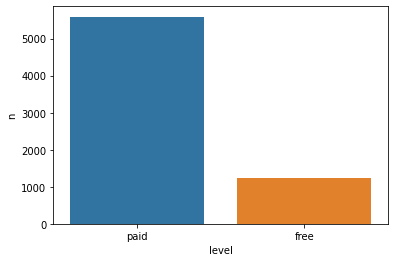

In [80]:
# Get number of different levels in the table songplays
levels_types = pd.read_sql_query("""
SELECT level, COUNT(1) as n 
FROM songplays
GROUP BY level
""", con = conn)

sns.barplot(data=levels_types, x = 'level', y='n');

As we can see, most of the rows in the table `songplays` they have the **paid** level.

<a id='clean'></a>
## Clean up the Redshift cluster and the IAM role

<b><font color='red'>DO NOT RUN THIS UNLESS YOU ARE SURE <br/></span></b>

Once we have executed all the analysis in our Redshift cluster and we don't need the data anymore we also can remove the Redshift cluster using code. In this case, first we will remove the Redshift cluster.

In [ ]:
# Delete the Redshift cluster
redshift.delete_cluster(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,  SkipFinalClusterSnapshot=True)

In [ ]:
# Check the status of the Redshift cluster
myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
prettyRedshiftProps(myClusterProps)

Once the Redshift cluster is deleted we delete the permission '0.0.0.0/0' in the security group of the Redshift cluster that we have created.

In [86]:
try:
    # Get the security group
    defaultSg = ec2.SecurityGroup(id=myClusterProps['VpcSecurityGroups'][0]['VpcSecurityGroupId'])
    
    # Revoke the permissions of '0.0.0.0/0' in the security group
    defaultSg.revoke_ingress(IpPermissions=defaultSg.ip_permissions)
except Exception as e:
    print(e)

Finally, we detach and delete the IAM role that we created before for the Redshift cluster.

In [87]:
# Delete the role policy attached to the IAM role that we have created
iam.detach_role_policy(RoleName=DWH_IAM_ROLE_NAME, PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess")

# Delete the IAM role
iam.delete_role(RoleName=DWH_IAM_ROLE_NAME)

{'ResponseMetadata': {'RequestId': '7e1eb85e-da3f-4af3-ae84-f7246b398b48',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7e1eb85e-da3f-4af3-ae84-f7246b398b48',
   'content-type': 'text/xml',
   'content-length': '200',
   'date': 'Sun, 17 May 2020 17:07:57 GMT'},
  'RetryAttempts': 0}}